In [1]:
# Forecasting the electric power consumption
# Objective : To predict the global active power and Sub_metering_2 for the next 1 hour.
# Benefit: Helps energy companies plan the load on the grid

# Global_active_power: The global active power in kilowatts (represents the real power used in a circuit)
# Sub_metering_2: Energy consumed in the laundry room by a washing machine, tumble-dryer, refrigerator, and light in watt-hours

# Import time module
from datetime import datetime as dt

# Record start time
start = dt.now()

import datetime

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
#  Set a random seed for numpy and TensorFlow, so that results can be reproduced
#tf.random.set_seed(51)
#np.random.seed(51)

In [3]:
# Focus on the electric consumption for a house in Sceaux,France, between December 2006 and November 2010
# The “household electric power consumption” dataset is available from the UC Irvine Machine Learning Repository

df = pd.read_csv('../data/household_power_consumption.txt', sep=';')
df.shape

(2075259, 9)

In [4]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [5]:
# Check if there are missing values
df.isnull().values.any()

True

In [6]:
# View missing values for each column of our dataset
df.isna().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [7]:
# View the length of the longest sequence of consecutive missing values
na_groups = df['Sub_metering_3'].notna().cumsum()[df['Sub_metering_3'].isna()]
len_consecutive_na = na_groups.groupby(na_groups).agg(len)
longest_na_gap = len_consecutive_na.max()
print(longest_na_gap)

7226


In [8]:
# Consecutive minutes of missing data, is too large to fill with missing values, so drop 'Sub_metering_3' from the dataset
df = df.drop(['Sub_metering_3'], axis=1)

In [9]:
# Check if there are still missing values
df.isnull().values.any()

False

In [10]:
df.describe()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
count,2075259,2075259,2075259,2075259,2075259,2075259,2075259,2075259
unique,1442,1440,6534,896,5168,377,153,145
top,6/12/2008,17:24:00,?,0.000,?,1.000,0.000,0.000
freq,1440,1442,25979,472786,25979,169406,1840611,1408274


In [11]:
# Check column types
df.dtypes

Date                     object
Time                     object
Global_active_power      object
Global_reactive_power    object
Voltage                  object
Global_intensity         object
Sub_metering_1           object
Sub_metering_2           object
dtype: object

In [12]:
# Convert non date and time columns to numerical values
cols_to_convert = df.columns[2:]

df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

In [13]:
# Confirm that conversion was as expected
df.dtypes

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
dtype: object

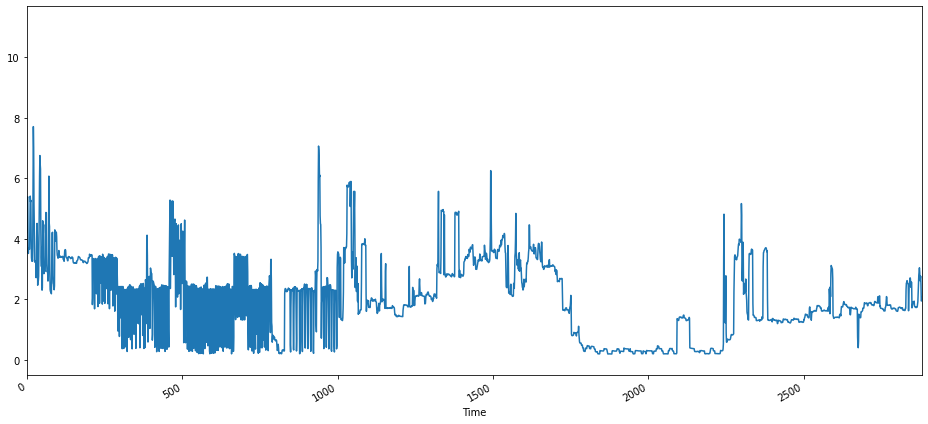

In [14]:
# Check if data sampled every minute is appropriate for modeling
fig, ax  = plt.subplots(figsize=(13, 6))

ax.plot(df['Global_active_power'])
ax.set_xlabel('Time')
ax.set_xlim(0, 2880)

fig.autofmt_xdate()
plt.tight_layout()

In [15]:
# Data is noisey with large oscillations ocurring every minute
# Resample data by the hour to hopefully smooth out and uncover a pattern that may be easier to predict with a ML model
# First create a new column of datetime data type by combining the Date and Time columns

df.insert(0, 'datetime', pd.to_datetime(df.Date.astype(str)+ ' ' + df.Time.astype(str))) 
df.head()

,datetime,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
0,2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0
1,2006-12-16 17:25:00,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0
2,2006-12-16 17:26:00,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0
3,2006-12-16 17:27:00,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0
4,2006-12-16 17:28:00,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0


In [16]:
# drop the unnecessary Date & Time fields
df = df.drop(['Date', 'Time'], axis=1)
df.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0


In [17]:
# Resample data by taking an hourly sum of each variable
hourly_df = df.resample('H', on='datetime').sum()
hourly_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
datetime,,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0


In [18]:
# Since the first and last rows of data do not have a full 60 minutes in their sum, so they are omitted
hourly_df = hourly_df.drop(hourly_df.tail(1).index)
hourly_df = hourly_df.drop(hourly_df.head(1).index)

In [19]:
# Reset the index of the dataframe
hourly_df = hourly_df.reset_index()
hourly_df.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
0,2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0
1,2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0
2,2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0
3,2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0
4,2006-12-16 22:00:00,132.008,3.370,14325.60,571.4,0.0,8.0


In [20]:
hourly_df.shape

(34949, 7)

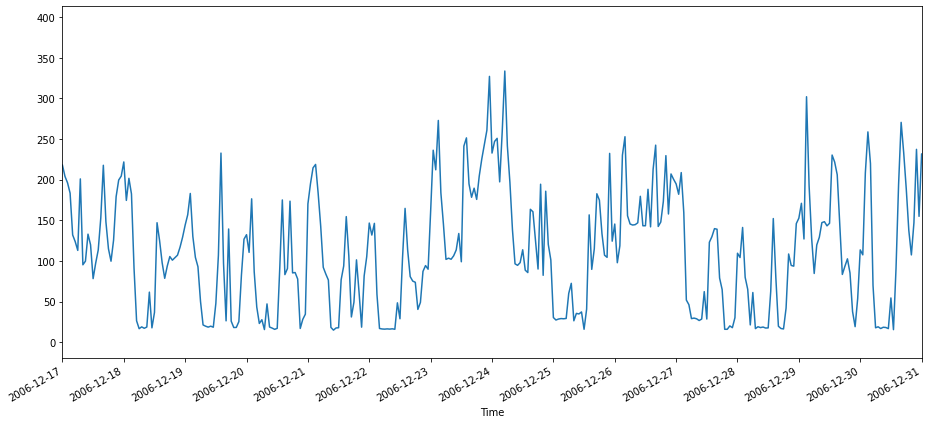

In [21]:
# Check if resampling our data generated a discernible pattern that can be forecast
fig, ax = plt.subplots(figsize=(13, 6))

ax.plot(hourly_df['Global_active_power'])
ax.set_xlabel('Time')
ax.set_xlim(0, 336)

plt.xticks(np.arange(0, 360, 24), ['2006-12-17', '2006-12-18', '2006-12-19', '2006-12-20', '2006-12-21', '2006-12-22',
                                    '2006-12-23', '2006-12-24', '2006-12-25', '2006-12-26', '2006-12-27', '2006-12-28',
                                    '2006-12-29', '2006-12-30', '2006-12-31'])

fig.autofmt_xdate()
plt.tight_layout()

In [22]:
# Save dataset as a CSV file 
hourly_df.to_csv('../data/clean_household_power_consumption.csv', header=True, index=False)

In [23]:
# Read data to begin feature engineering
hourly_df = pd.read_csv('../data/clean_household_power_consumption.csv')
hourly_df.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
0,2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0
1,2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0
2,2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0
3,2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0
4,2006-12-16 22:00:00,132.008,3.370,14325.60,571.4,0.0,8.0


In [24]:
hourly_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Global_active_power,34949.0,64.002817,54.112103,0.0,19.974,45.868,93.738,393.632
Global_reactive_power,34949.0,7.253838,4.113238,0.0,4.558,6.324,8.884,46.460
Voltage,34949.0,14121.298311,2155.548246,0.0,14340.300,14454.060,14559.180,15114.120
Global_intensity,34949.0,271.331557,226.626113,0.0,88.400,196.600,391.600,1703.000
Sub_metering_1,34949.0,65.785430,210.107036,0.0,0.000,0.000,0.000,2902.000
Sub_metering_2,34949.0,76.139861,248.978569,0.0,0.000,19.000,39.000,2786.000


In [25]:
# Remove column 'Sub_meeting_1' since it doesn't vary much over time and thus can't be a good predictor
hourly_df = hourly_df.drop(['Sub_metering_1'], axis=1)

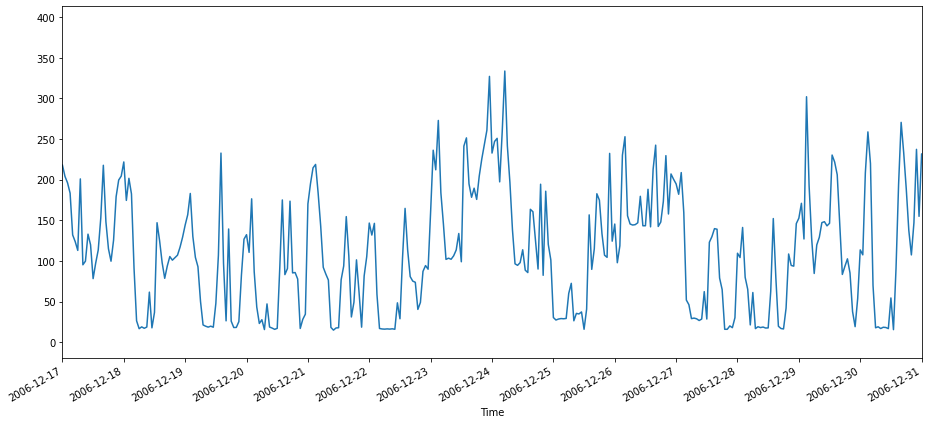

In [26]:
# Plot data to visually identify seasonal period
fig, ax = plt.subplots(figsize=(13,6))

ax.plot(hourly_df['Global_active_power'])
ax.set_xlabel('Time')
ax.set_xlim(0, 336)

plt.xticks(np.arange(0, 360, 24), ['2006-12-17', '2006-12-18', '2006-12-19', '2006-12-20', '2006-12-21', '2006-12-22',
                                    '2006-12-23', '2006-12-24', '2006-12-25', '2006-12-26', '2006-12-27', '2006-12-28',
                                    '2006-12-29', '2006-12-30', '2006-12-31'])

fig.autofmt_xdate()
plt.tight_layout()

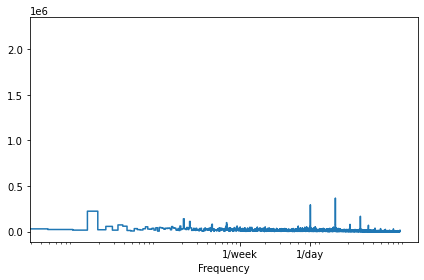

In [27]:
# There is clear cyclical behavior, the seasonal period is hard to determine from the graph. 
# To ascertain that there is daily seasonality in the data, use Fourier transform
# A Fourier transform allows us to visualize the frequency and amplitude of a signal

# Apply a Fourier transform on our target
fft = tf.signal.rfft(hourly_df['Global_active_power'])

# Get the number of frequencies from the Fourier transform
f_per_dataset = np.arange(0, len(fft))

# Find out how many hours are in the dataset
n_sample_h = len(hourly_df['Global_active_power'])

# Get the number of hours in a week
hours_per_week = 24 * 7
# Get the number of weeks in the dataset
weeks_per_dataset = n_sample_h / hours_per_week
# Get the frequency of a week in the dataset
f_per_week = f_per_dataset / weeks_per_dataset

# Plot the frequency and amplitude
plt.step(f_per_week, np.abs(fft))
plt.xscale('log')
# Label the weekly and daily frequencies
plt.xticks([1,7], ['1/week', '1/day'])
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

In [28]:
# The weekly frequency does not show any visible peak, meaning that its amplitude is very small - no weekly seasonality
# The daily frequency, has a clear peak in the figure - there is daily seasonality in our data

In [29]:
# Encode our timestamp using a sine/cosine transformation to express the time while keeping its daily seasonal information

timestamp_s = pd.to_datetime(hourly_df.datetime).map(datetime.datetime.timestamp)

day = 24 * 60 * 60

hourly_df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
hourly_df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values

hourly_df = hourly_df.drop(['datetime'], axis=1)

In [30]:
# Split the dataset into training, validation, and test sets
n = len(hourly_df)

# Split 70:20:10 (train:validation:test)
train_df = hourly_df[0:int(n*0.7)]
val_df = hourly_df[int(n*0.7):int(n*0.9)]
test_df = hourly_df[int(n*0.9):]

In [31]:
# Fit the scaler to the training set only, and scale each individual set
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

In [32]:
train_df.to_csv('../data/ch18_train.csv', index=False, header=True)
val_df.to_csv('../data/ch18_val.csv', index=False, header=True)
test_df.to_csv('../data/ch18_test.csv', index=False, header=True)

In [33]:
# Preparing for modeling with deep learning 
# Objective : To predict the global active power and Sub_metering_2 for the next 1 hour.
# Solution: Build a multi-output model
# The following models are to be built for comparison in order to determine the one with the least MAE: 
# 1. A baseline model
# 2. A linear model, 
# 3. A deep neural network model, 
# 4. A long short-term memory (LSTM) model, 
# 5. A convolutional neural network (CNN), 
# 6. A combination of CNN and LSTM, 

In [34]:
# Initial setup
from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

In [35]:
# Read custom classes and functions

from myDataWindow import DataWindow
from myBaseline import Baseline
from myMultiStepLastBaseline import MultiStepLastBaseline
from myRepeatBaseline import RepeatBaseline
from myDeepFunctions import compile_and_fit
from myAutoRegressive import AutoRegressive

In [36]:
# for reproduceability set random seeds
tf.random.set_seed(51)
np.random.seed(51)

In [37]:
# set parameters for the plots - specify a size and remove the grid on the axes

plt.rcParams['figure.figsize'] = (12, 7.5)
plt.rcParams['axes.grid'] = False

In [38]:
# read the training set, validation set, and test set
train_df = pd.read_csv('../data/ch18_train.csv')
val_df = pd.read_csv('../data/ch18_val.csv')
test_df = pd.read_csv('../data/ch18_test.csv')

In [39]:
# Build a dictionary to store the column names and their corresponding indexes.
# This can be useful later on for building the baseline models and creating windows of data

column_indices = {name: i for i, name in enumerate(train_df.columns)}

In [40]:
# Notice that we pass in both Sub_metering_2 and Global_active_power, as those are our two targets for 
# the multi-output model.
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, 
                                   train_df=train_df,
                                   val_df=val_df, 
                                   test_df=test_df,
                                   label_columns=['Sub_metering_2', 'Global_active_power'])

wide_window = DataWindow(input_width=24, label_width=24, shift=1, 
                                   train_df=train_df,
                                   val_df=val_df, 
                                   test_df=test_df,
                                   label_columns=['Sub_metering_2', 'Global_active_power'])

# For multi-output model, pass the indexes of the Sub_metering_2 and Global_active_power columns to output 
# the last known value for the respective variables as a prediction

print(column_indices['Global_active_power'])
print(column_indices['Sub_metering_2'])

0
4


In [41]:
# 1. Baseline - repeats the last known value
baseline_last = Baseline(label_index = [0, 4])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(wide_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(wide_window.test, verbose=0)

218/218 [==============================] - 4s 11ms/step - loss: 0.0396 - mean_absolute_error: 0.1547


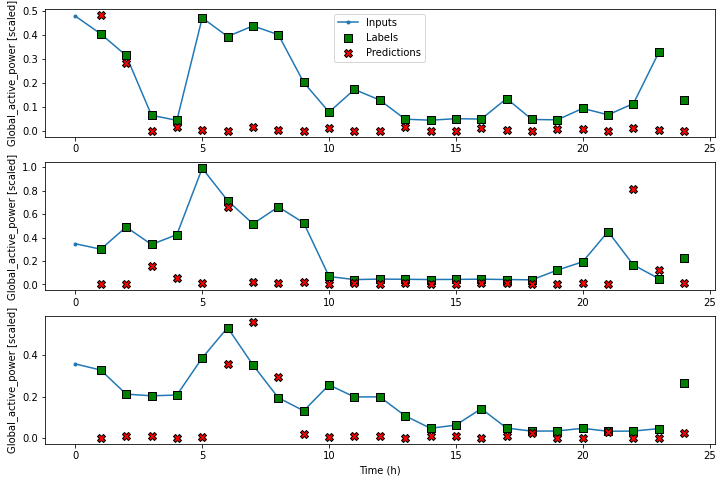

In [42]:
wide_window.plot(baseline_last, plot_col='Global_active_power')

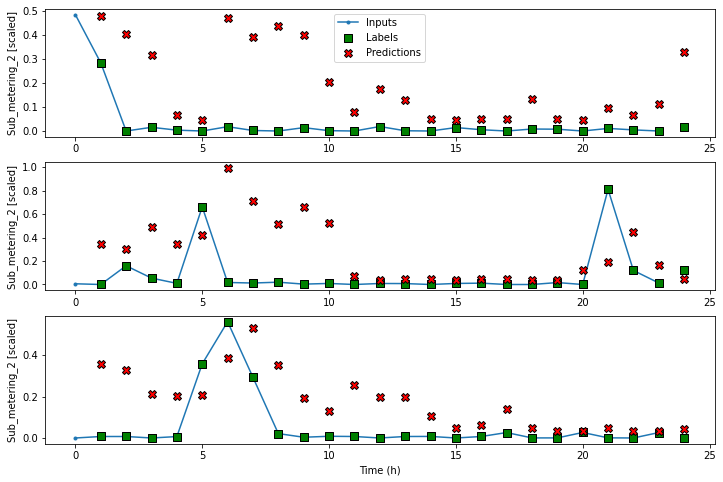

In [43]:
wide_window.plot(baseline_last, plot_col='Sub_metering_2')

In [44]:
print(performance['Baseline - Last'][1])

0.12267222255468369


In [45]:
# 2. Linear Model
# We set units equal to the number of targets we are predicting in the output layer

#label_index = column_indices['Global_active_power']
#num_features = train_df.shape[1]

linear = Sequential([Dense(units = 2)])

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
765/765 [==============================] - 15s 18ms/step - loss: 0.0505 - mean_absolute_error: 0.1591 - val_loss: 0.0183 - val_mean_absolute_error: 0.0897mean_absolute_error: 0.
Epoch 2/50
765/765 [==============================] - 27s 36ms/step - loss: 0.0127 - mean_absolute_error: 0.0700 - val_loss: 0.0106 - val_mean_absolute_error: 0.0630
Epoch 3/50
765/765 [==============================] - 12s 16ms/step - loss: 0.0096 - mean_absolute_error: 0.0582 - val_loss: 0.0093 - val_mean_absolute_error: 0.0570
Epoch 4/50
765/765 [==============================] - 15s 20ms/step - loss: 0.0089 - mean_absolute_error: 0.0547 - val_loss: 0.0088 - val_mean_absolute_error: 0.0539 loss: 0.0089 
Epoch 5/50
765/765 [==============================] - 13s 17ms/step - loss: 0.0086 - mean_absolute_error: 0.0531 - val_loss: 0.0085 - val_mean_absolute_error: 0.0519
Epoch 6/50
765/765 [==============================] - 14s 18ms/step - loss: 0.0085 - mean_absolute_error: 0.0525 - val_loss: 0.0083 -

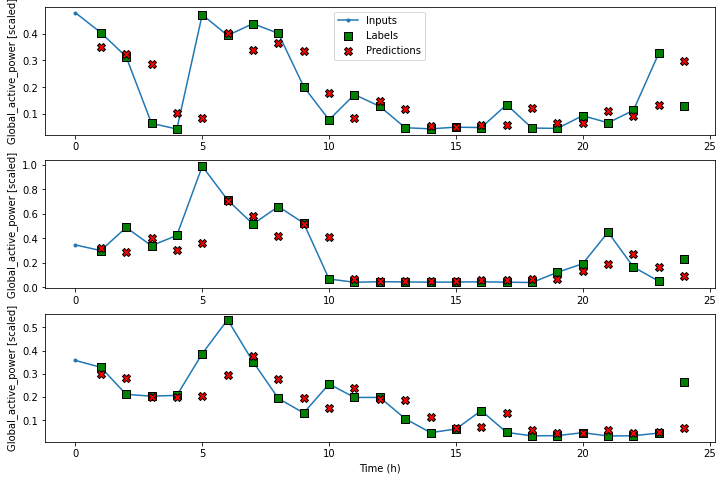

In [46]:
wide_window.plot(linear, plot_col='Global_active_power')

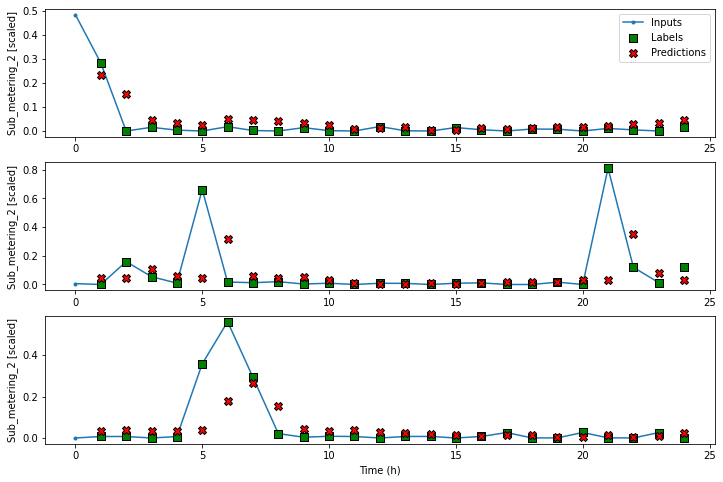

In [47]:
wide_window.plot(linear, plot_col='Sub_metering_2')

In [48]:
print(performance['Linear'][1])

0.04108213633298874


In [49]:
# 3. A Deep Neural Network model
# Stack two dense layers of 64 neurons each with ReLU as the activation function

dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    # The output layer has two neurons, since we are forecastin two targets 
    Dense(units=2),
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
765/765 [==============================] - 24s 25ms/step - loss: 0.0082 - mean_absolute_error: 0.0531 - val_loss: 0.0070 - val_mean_absolute_error: 0.0520 mean_absolute_error: 0
Epoch 2/50
765/765 [==============================] - 36s 47ms/step - loss: 0.0077 - mean_absolute_error: 0.0502 - val_loss: 0.0065 - val_mean_absolute_error: 0.0457
Epoch 3/50
765/765 [==============================] - 20s 26ms/step - loss: 0.0075 - mean_absolute_error: 0.0492 - val_loss: 0.0067 - val_mean_absolute_error: 0.0473oss: 0.0072 - mean_absolute_error:
Epoch 4/50
765/765 [==============================] - 12s 15ms/step - loss: 0.0075 - mean_absolute_error: 0.0489 - val_loss: 0.0068 - val_mean_absolute_error: 0.0521
Epoch 5/50
219/219 [==============================] - 3s 13ms/step - loss: 0.0066 - mean_absolute_error: 0.0465


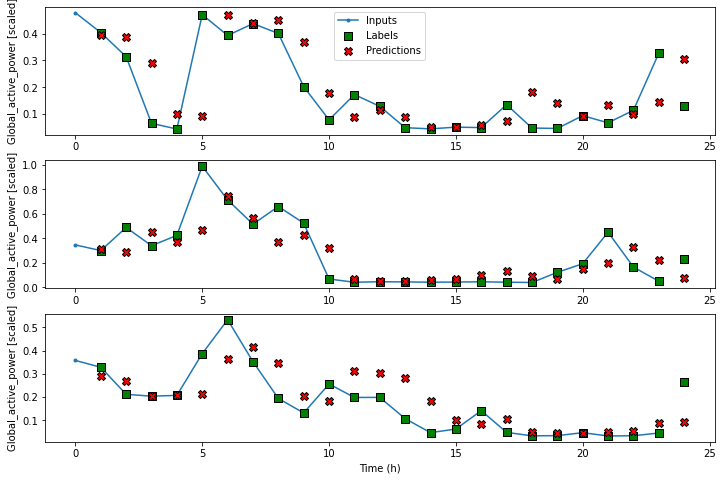

In [50]:
wide_window.plot(dense, plot_col='Global_active_power')

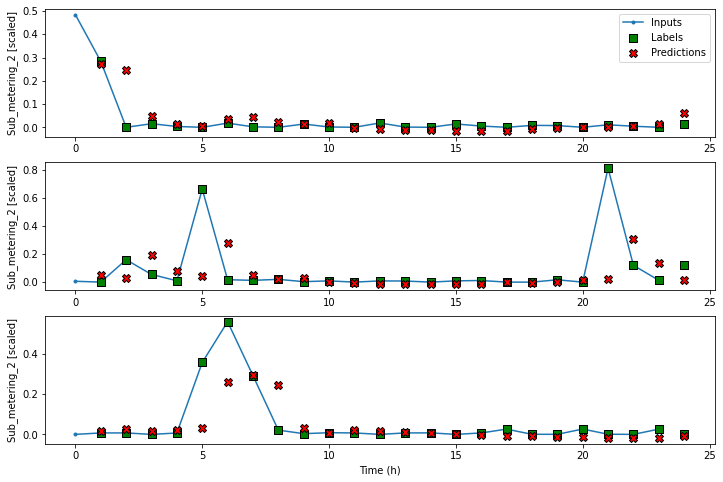

In [51]:
wide_window.plot(dense, plot_col='Sub_metering_2')

In [52]:
print(performance['Dense'][1])

0.04033779725432396


In [53]:
# 4. A long short-term memory (LSTM) model
# Key benefit: It allows us to combine information from the present and the past to produce a prediction

lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    # Two units for two targets i.e. Global_intensity & Global_active_power
    Dense(units=2),
])

history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
764/764 [==============================] - 43s 47ms/step - loss: 0.0099 - mean_absolute_error: 0.0599 - val_loss: 0.0069 - val_mean_absolute_error: 0.0508
Epoch 2/50
764/764 [==============================] - 34s 44ms/step - loss: 0.0077 - mean_absolute_error: 0.0501 - val_loss: 0.0066 - val_mean_absolute_error: 0.0468
Epoch 3/50
764/764 [==============================] - 34s 44ms/step - loss: 0.0076 - mean_absolute_error: 0.0493 - val_loss: 0.0065 - val_mean_absolute_error: 0.0464
Epoch 4/50
764/764 [==============================] - 38s 50ms/step - loss: 0.0075 - mean_absolute_error: 0.0488 - val_loss: 0.0065 - val_mean_absolute_error: 0.0455
Epoch 5/50
764/764 [==============================] - 37s 49ms/step - loss: 0.0074 - mean_absolute_error: 0.0484 - val_loss: 0.0064 - val_mean_absolute_error: 0.0452
Epoch 6/50
764/764 [==============================] - 36s 48ms/step - loss: 0.0073 - mean_absolute_error: 0.0479 - val_loss: 0.0063 - val_mean_absolute_error: 0.0457
Epoc

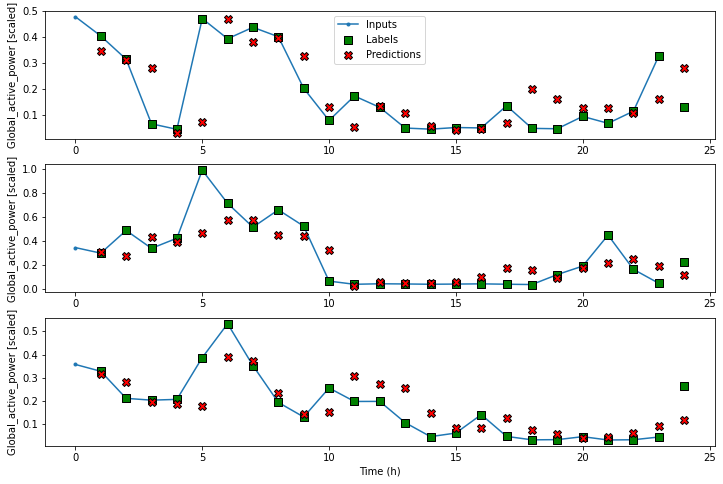

In [54]:
wide_window.plot(lstm_model, plot_col='Global_active_power')

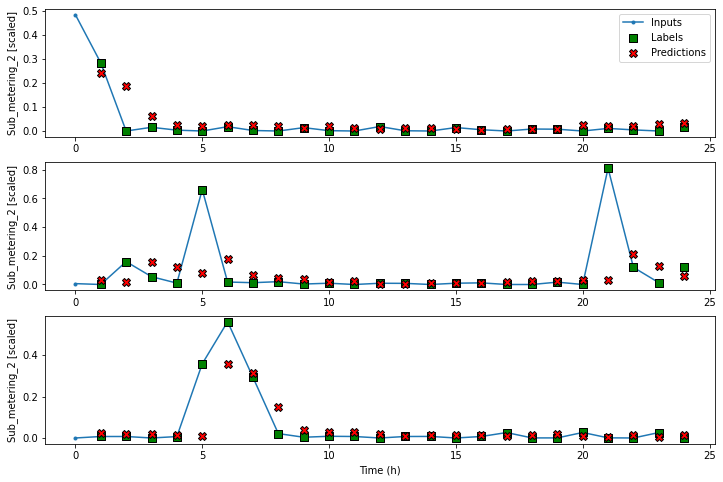

In [55]:
wide_window.plot(lstm_model, plot_col='Sub_metering_2')

In [56]:
print(performance['LSTM'][1])

0.038982097059488297


In [57]:
# 5. A convolutional neural network (CNN)
# Key benefit: Reduce the feature space by filtering our time series and performing feature selection
# Forecast the Global_intensity and Global_active_power for the next timestep only
# output length = input length – kernel length + 1
# input length = output length + kernel length – 1

KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

wide_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1,
                        train_df=train_df,
                        val_df=val_df,
                        test_df=test_df,
                        label_columns=['Sub_metering_2', 'Global_active_power'])

cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(cnn_model, wide_conv_window)

val_performance['CNN'] = cnn_model.evaluate(wide_conv_window.val)
performance['CNN'] = cnn_model.evaluate(wide_conv_window.test, verbose=0)

Epoch 1/50
764/764 [==============================] - 17s 20ms/step - loss: 0.0084 - mean_absolute_error: 0.0523 - val_loss: 0.0064 - val_mean_absolute_error: 0.0456oss: 0.0108 - mean_absolute_error: 0. - ETA: 5s - loss - ETA: 3s - loss - ETA: 1s - loss: 0.0085 - mean_absol
Epoch 2/50
764/764 [==============================] - 15s 20ms/step - loss: 0.0071 - mean_absolute_error: 0.0469 - val_loss: 0.0062 - val_mean_absolute_error: 0.0448
Epoch 3/50
764/764 [==============================] - 18s 24ms/step - loss: 0.0069 - mean_absolute_error: 0.0463 - val_loss: 0.0062 - val_mean_absolute_error: 0.0456
Epoch 4/50
764/764 [==============================] - 15s 20ms/step - loss: 0.0068 - mean_absolute_error: 0.0459 - val_loss: 0.0062 - val_mean_absolute_error: 0.0444
Epoch 5/50
764/764 [==============================] - 15s 20ms/step - loss: 0.0068 - mean_absolute_error: 0.0456 - val_loss: 0.0063 - val_mean_absolute_error: 0.0450
Epoch 6/50
764/764 [==============================] - 15s 19m

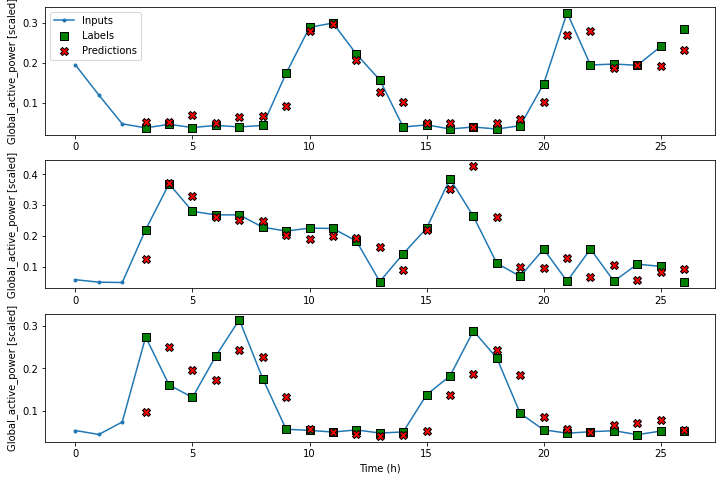

In [58]:
wide_conv_window.plot(cnn_model, plot_col='Global_active_power')

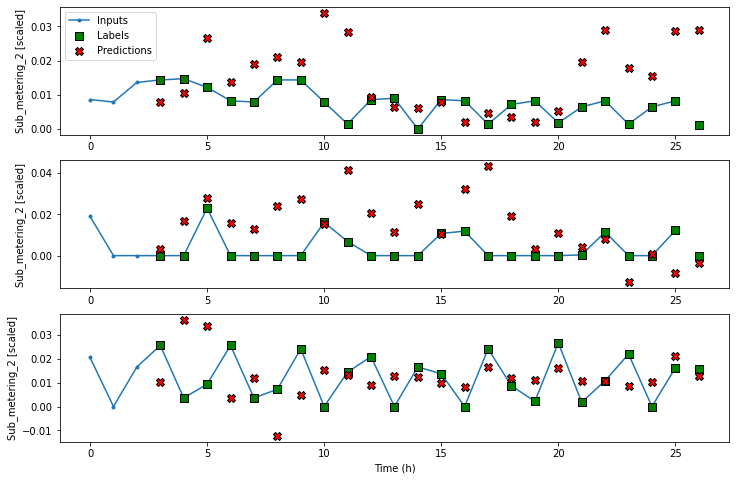

In [59]:
wide_conv_window.plot(cnn_model, plot_col='Sub_metering_2')

In [60]:
print(performance['CNN'][1])

0.03715856745839119


In [61]:
# 6. A combination of CNN and LSTM
# Note: LSTM is good at treating sequences of data, while CNN can filter a sequence of data

cnn_lstm_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    LSTM(32, return_sequences=True),
    Dense(units=2)
])

history = compile_and_fit(cnn_lstm_model, wide_conv_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(wide_conv_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(wide_conv_window.test, verbose=0)

Epoch 1/50
764/764 [==============================] - 53s 58ms/step - loss: 0.0092 - mean_absolute_error: 0.0563 - val_loss: 0.0064 - val_mean_absolute_error: 0.0459
Epoch 2/50
764/764 [==============================] - 41s 54ms/step - loss: 0.0072 - mean_absolute_error: 0.0477 - val_loss: 0.0063 - val_mean_absolute_error: 0.0444
Epoch 3/50
764/764 [==============================] - 54s 71ms/step - loss: 0.0070 - mean_absolute_error: 0.0470 - val_loss: 0.0063 - val_mean_absolute_error: 0.0445
Epoch 4/50
764/764 [==============================] - 44s 58ms/step - loss: 0.0069 - mean_absolute_error: 0.0465 - val_loss: 0.0062 - val_mean_absolute_error: 0.0436
Epoch 5/50
764/764 [==============================] - 46s 60ms/step - loss: 0.0069 - mean_absolute_error: 0.0461 - val_loss: 0.0061 - val_mean_absolute_error: 0.0441
Epoch 6/50
764/764 [==============================] - 44s 58ms/step - loss: 0.0068 - mean_absolute_error: 0.0459 - val_loss: 0.0061 - val_mean_absolute_error: 0.0449
Epoc

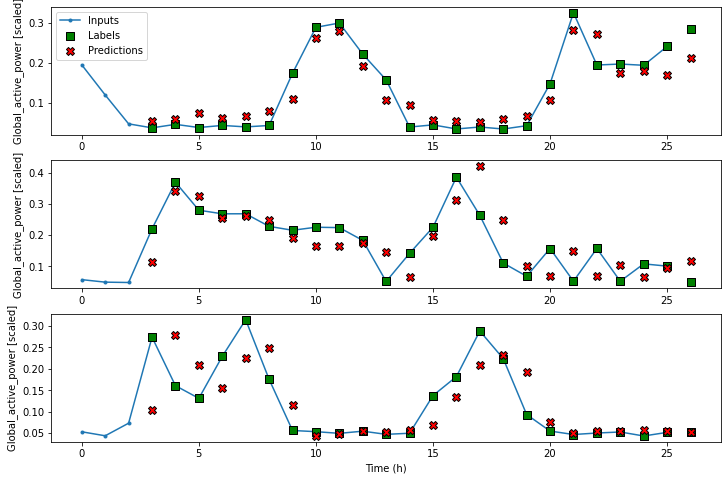

In [62]:
wide_conv_window.plot(cnn_lstm_model, plot_col='Global_active_power')

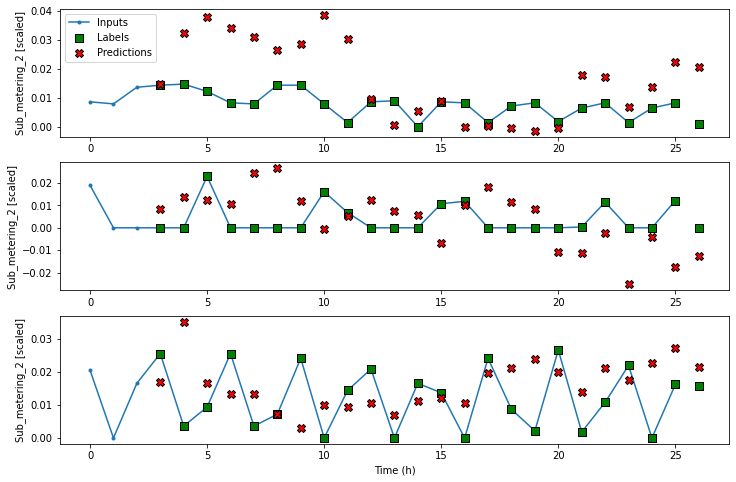

In [63]:
wide_conv_window.plot(cnn_lstm_model, plot_col='Sub_metering_2')

In [64]:
print(performance['CNN + LSTM'][1])

0.038950756192207336


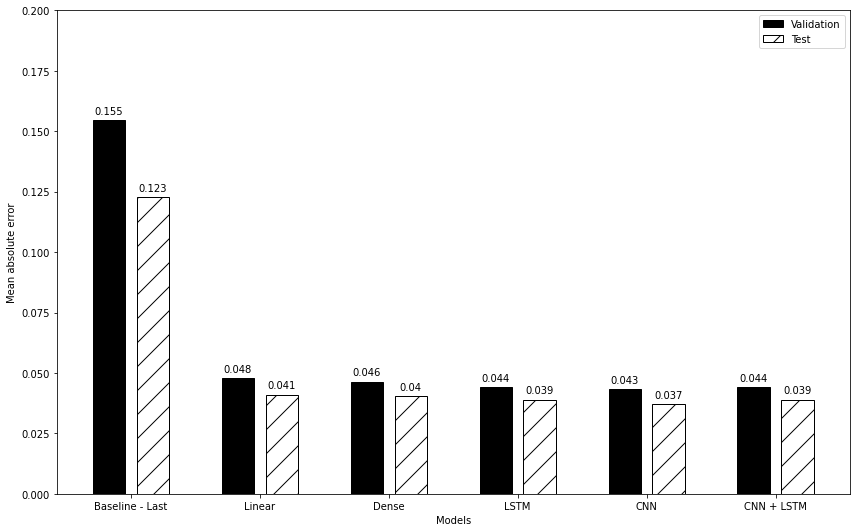

In [65]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots(figsize=(12, 7.5))
ax.bar(x - 0.17, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.17, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.17, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mae_test):
    plt.text(x=index + 0.17, y = value+0.0025, s=str(round(value, 3)), ha='center')
    
plt.ylim(0, 0.2)
plt.xticks(ticks=x, labels=performance.keys())

plt.legend(loc='best')
plt.tight_layout()

In [66]:
# Record end time
end = dt.now()
elapsed = end - start

print("The program took: %02d:%02d:%02d:%02d" % (elapsed.days, elapsed.seconds // 3600, elapsed.seconds // 60 % 60, elapsed.seconds % 60))

The program took: 00:00:52:17
